In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
import seaborn as sns

np.random.seed(39)

# plt.rcParams['figure.facecolor'] = 'white'

In [2]:
pos_min, pos_max, = -100, 100
n_demand = 2000
n_fix_supply = 8
n_new_supply = 20
supply_types = 4
n_ages = 4
demand_pos = np.random.uniform(pos_min, pos_max, (n_demand,2))
fix_supply_pos = np.random.uniform(pos_min, pos_max, (n_fix_supply,2))
new_supply_pos = np.random.uniform(pos_min, pos_max, (n_new_supply,2))
ages = np.random.randint(0, 120, (n_demand,n_ages))
# Costo para la persona de edad i en el establecimiento j
#                          Ninguno,Urgencias,Prevencion,Hospital 
#                           Ninguno, Urgencias, Rutinarios, Hospital 
costs_age_type = np.array([[np.infty, 0.110659, 0.38995,  0.031499], # <5
                           [np.infty, 0.06155,  0.133497,  0.017098], # 5-14
                           [np.infty, 0.04745,  0.143398,  0.014685], # 15-64
                           [np.infty, 0.006358, 0.04012,  0.003735]]) # >64

ages_demand = np.array(np.mat(ages)*np.mat(costs_age_type))
supply_price = [0, 40, 25, 100] # Ninguno, Urgencias, Rutinarios, Hospital
fixed_types = np.random.randint(1, supply_types, (n_fix_supply))
budget = 140

In [3]:
# Atencion    Urgencias Rutinarias Hospitales  
# Edad<5      0.09854   0.03683    0.250181    
# Edad5-14    0.056234  0.012938   0.139365    
# Edad15-64   0.044939  0.014407   0.124108    
# Edad>64     0.032173  0.0216     0.168686     

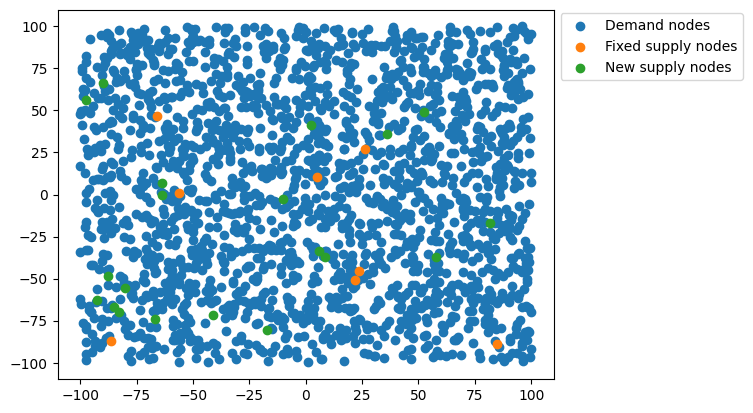

In [4]:
plt.scatter(demand_pos[:,0],demand_pos[:,1], label = 'Demand nodes')
plt.scatter(fix_supply_pos[:,0],fix_supply_pos[:,1], label = 'Fixed supply nodes')
plt.scatter(new_supply_pos[:,0],new_supply_pos[:,1], label = 'New supply nodes')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.9))
plt.show()

In [5]:
# Distancia l1 entre nodos de demanda y oferta
def l1_distance(demand_pos, supply_pos):
    distance = np.zeros((len(demand_pos),len(supply_pos)))
    for i in range(len(demand_pos)):
        for j in range(len(supply_pos)):
            distance[i,j] = np.abs(demand_pos[i,0] - supply_pos[j,0]) + np.abs(demand_pos[i,1] - supply_pos[j,1])
    return distance

def euc_distance(demand_pos, supply_pos):
    distance = np.zeros((len(demand_pos),len(supply_pos)))
    for i in range(len(demand_pos)):
        for j in range(len(supply_pos)):
            distance[i,j] = np.sqrt((demand_pos[i,0] - supply_pos[j,0])**2) + np.sqrt((demand_pos[i,1] - supply_pos[j,1])**2)
    return distance

In [6]:
# distance = l1_distance(demand_pos, supply_pos)
fix_distance = euc_distance(demand_pos, fix_supply_pos)
new_distance = euc_distance(demand_pos, new_supply_pos)

In [7]:
# Definicion de los vectores de instalaciones, estos representan el tipo de instalacion
fixed_types = np.random.randint(1, supply_types, (n_fix_supply))
# Los nodos fijos tiene valores de 1 a 3 y los nuevos pueden ser de 0 a 3, siendo 0 que no esta instalado
new_types = np.random.randint(0, supply_types, (n_new_supply))

In [8]:
# Se define la poblacion de opciones, donde cada individuo representa una posible 
# posicion de cada establecimiento, siendo 1 a 3 cada tipo y 0 ninguno
def create_population(n_individuals, n_new_supply, supply_types):
    return np.random.randint(0, supply_types, (n_individuals,n_new_supply))

# Funcion que asigna cada nodo de demanda al establecimiento con menor costo por distancia
# Considerando el costo por cada tipo de los fijos y los nuevos, ademas entrega el costo de la solucion
def asignation(supplys_types, distances, ages_demand):
    asig = np.zeros(distances.shape[0], dtype=int)
    sol_cost = 0
    for i in range(distances.shape[0]):
        weighted_dists = distances[i]*np.array([ages_demand[i,j] for j in supplys_types])
        pos = np.nanargmin(weighted_dists)
        asig[i] = pos
        sol_cost += weighted_dists[pos]
    return asig, sol_cost

# Penalizacion por superar el presupuesto, este depende de cuan pasado esta y un factor de penalizacion
def penalization(individual, budget, supply_price, penalizations):
    expense = sum([supply_price[i] for i in individual])
    return expense*penalizations if expense>budget else 0

# Valor a minimizar, considera la suma de costos y la penalizacion
def score(individual, fixed_types, fix_distance, new_distance, 
          ages_demand, budget, supply_price, penalizations):
    supplys_types = np.hstack((fixed_types,individual))
    distances = np.hstack((fix_distance,new_distance))
    asig, sol_cost = asignation(supplys_types, distances, ages_demand)
    return (sol_cost + penalization(individual, budget, supply_price, penalizations))

# Funcion de seleccion, elige los n mejores individuos 
def selection(population, scores, n_selected):
    selected = []
    for i in np.argsort(scores)[:n_selected]:
        selected.append(population[i])
    return selected

# Toma los n mejores individuos y los replica en la nueva poblacion
# def reproduction(population, selected):
#     groups = int(population.shape[0]/len(selected))
#     for i in range(population.shape[0]):
#         for j in range(groups):
#             population[groups*i+j] = selected[j]
#     return population

# # Selecciona 2 de los mejores individuos y los mezcla para crear uno nuevo
def reproduction(population, selected):
    for i in range(population.shape[0]):
        fathers = np.random.randint(0, len(selected), 2)        
        point = np.random.randint(1, population.shape[1] - 1)
        population[i][:point] = selected[fathers[0]][:point]
        population[i][point:] = selected[fathers[1]][point:]
    return population

# Aleatoriamente un gen de cada individuo cambia
# esto varia si se instala o no un establecimiento y su tipo
def mutation(population, supply_types, mutation_rate):
    for individual in population:
        for i in range(len(individual)):
            if np.random.uniform(0,1)<=mutation_rate:
                individual[i] = np.random.randint(0,supply_types)
    return population

def run(n_demand, supply_types, n_new_supply, fixed_types, fix_distance, new_distance,
        penalizations, ages_demand, n_individuals, n_selected, n_generations):
    population = create_population(n_individuals, n_new_supply, supply_types)
    best_score = np.inf
    mean_scores = []
    for i in range(n_generations):
        scores = [score(individual, fixed_types, fix_distance, new_distance, 
                  ages_demand, budget, supply_price, penalizations) for individual in population]
        best = np.argmin(scores)
        mean_scores.append(scores[best])
        if scores[best] < best_score:
            best_sol = population[best].copy()
            best_score = scores[best]
            print(i, np.round(best_score), best_sol)
        selected = selection(population, scores, n_selected)
        population = reproduction(population, selected)
        population = mutation(population, supply_types, mutation_rate)
    return mean_scores, best_sol

In [9]:
penalizations = 30000
n_individuals = 100
n_selected = 4
n_generations = 100
mutation_rate = 0.2

scores, sol = run(n_demand, supply_types, n_new_supply, fixed_types, fix_distance, new_distance, 
                  penalizations, ages_demand, n_individuals, n_selected, n_generations)

0 14324547.0 [2 2 0 0 1 0 1 0 2 1 0 0 1 2 1 1 2 1 2 2]
1 13630527.0 [0 2 0 0 1 0 1 2 3 0 2 0 1 2 2 2 2 1 0 0]
2 10315110.0 [0 2 0 0 0 2 0 2 2 0 2 2 1 2 0 2 0 1 0 1]
3 10044328.0 [0 2 0 0 0 2 0 2 0 0 2 2 0 2 3 0 0 1 0 2]
4 8057436.0 [0 0 0 0 0 2 0 2 0 0 1 2 2 2 0 0 0 1 0 1]
6 6863980.0 [0 2 2 0 0 0 0 1 0 0 2 0 2 0 0 0 0 2 0 1]
8 5832999.0 [1 0 0 0 0 2 0 0 0 0 0 0 0 1 0 0 0 1 0 2]
14 690653.0 [0 0 0 0 0 0 0 0 0 0 1 0 2 0 0 2 1 0 0 0]
97 688661.0 [0 0 0 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0]
133 627041.0 [0 0 0 0 0 0 0 1 0 0 0 0 3 0 0 0 0 0 0 0]
186 596535.0 [3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0]


[3 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0] 0


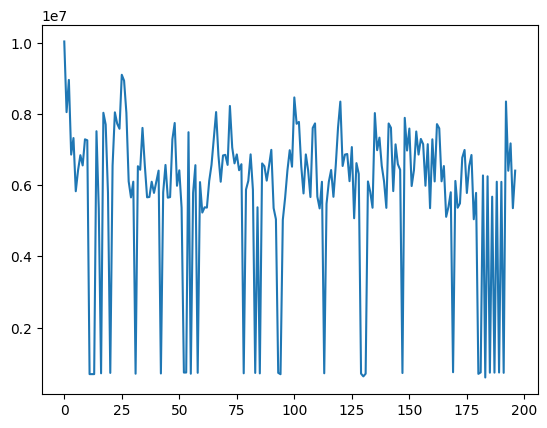

In [10]:
print(sol, penalization(sol, budget, supply_price, penalizations))
plt.plot(scores[3:])
plt.show()

In [13]:
supplys_types = np.hstack((fixed_types,sol))
supply_pos = np.vstack((fix_supply_pos,new_supply_pos))
distances = np.hstack((fix_distance,new_distance))
asig, value = asignation(supplys_types, distances, ages_demand)

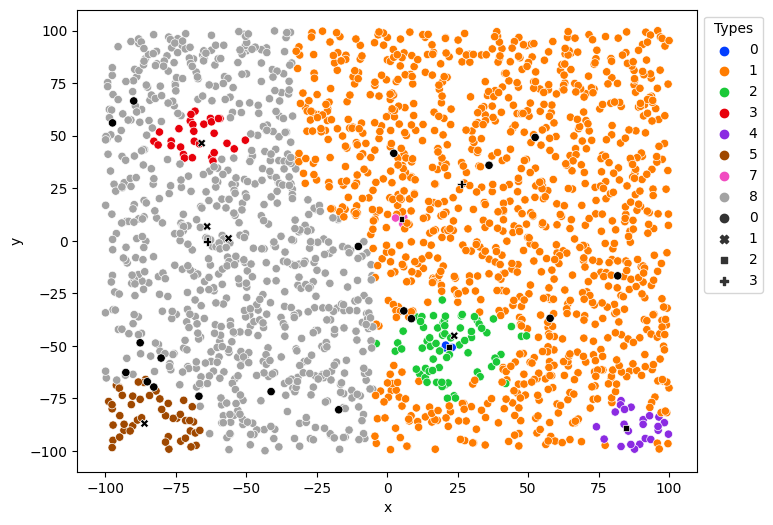

In [14]:
def asignation_plot(asig, demand_pos, supply_pos, supplys_types):
    supply = pd.DataFrame(supply_pos, columns=['x','y'])
    supply['Types'] = supplys_types
    demand = pd.DataFrame(demand_pos, columns=['x','y'])
    demand['Asignation'] = asig
    plt.figure(figsize = (8,6))
    ax = sns.scatterplot(data=demand, x = 'x', y = 'y', hue = 'Asignation', palette = 'bright')
    sns.scatterplot(ax = ax, data=supply, x = 'x', y = 'y', style = 'Types', color = 'k')
    # sns.scatterplot(ax = ax, data=supply_pos)
    sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
    plt.plot()
asignation_plot(asig, demand_pos, supply_pos, supplys_types)